# Data Analysis - Adventure Works 2022

In [1]:
from sqlalchemy import create_engine
from scipy import stats
from scipy.stats import t
from tabulate import tabulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
engine = create_engine(f'mssql://KAWSER/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server')
connection = engine.connect()

# 1. Descriptive analysis
## 1.1 Employee demographics overview

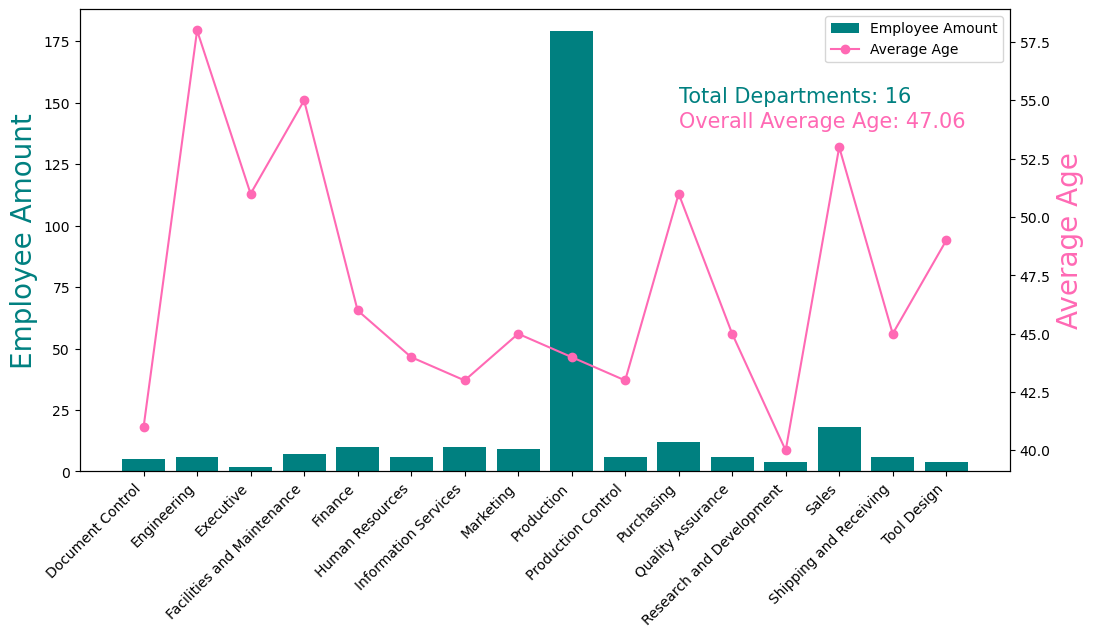

In [4]:
#An overview to analyze employee distribution and average age across departments
department_query = """
SELECT 
    A.Name AS DepartmentName,
    COUNT(C.BusinessEntityID) AS EmployeeCount,
    AVG(DATEDIFF(year, C.BirthDate, GETDATE())) AS AverageAge
FROM HumanResources.Department AS A
JOIN HumanResources.EmployeeDepartmentHistory AS B 
    ON A.DepartmentID = B.DepartmentID
JOIN HumanResources.Employee AS C
    ON C.BusinessEntityID = B.BusinessEntityID
    AND B.EndDate IS NULL
GROUP BY A.Name;"""

department_data = pd.read_sql(department_query, con=connection)

#Using a dual axis plot to visualize both employee counts and average ages
fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx() #Creates our dual graph

bar_plot= ax1.bar(department_data['DepartmentName'], department_data['EmployeeCount'], color='teal')
line_plot= ax2.plot(department_data['DepartmentName'], department_data['AverageAge'], color='hotpink', marker='o')

ax1.set_ylabel('Employee Amount', color='teal', size=20)
ax2.set_ylabel('Average Age', color='hotpink', size=20)

ax1.set_xticks(range(len(department_data['DepartmentName'])))
ax1.set_xticklabels(department_data['DepartmentName'], rotation=45, ha='right')

ax1.legend([bar_plot, line_plot[0]], ['Employee Amount', 'Average Age'], loc='upper right')

#Adding additional text to make a quick summary of the dataset and enhance the information
total_departments = len(department_data)
average_age = department_data['AverageAge'].mean()
ax1.text(10,150, f'Total Departments: {total_departments}', fontsize=15, color='teal')
ax1.text(10,140, f'Overall Average Age: {average_age:.2f}', fontsize=15, color='hotpink')

plt.show()

## 1.2 Purchase analysis
- Which vendor does Adventure Works Cycles purchase the most from? 
- What is the total number of suppliers registered in the database?
- Are there any suppliers marked as inactive in the database?

╒════╤═══════════════════════════════════╤════════════════════════╤════════════════════════╕
│    │ Vendor Name                       │   Total Amount Ordered │   Average Order Amount │
╞════╪═══════════════════════════════════╪════════════════════════╪════════════════════════╡
│  0 │ Superior Bicycles                 │            5.03427e+06 │               100685   │
├────┼───────────────────────────────────┼────────────────────────┼────────────────────────┤
│  1 │ Professional Athletic Consultants │            3.37995e+06 │                67598.9 │
├────┼───────────────────────────────────┼────────────────────────┼────────────────────────┤
│  2 │ Chicago City Saddles              │            3.34717e+06 │                65630.7 │
├────┼───────────────────────────────────┼────────────────────────┼────────────────────────┤
│  3 │ Jackson Authority                 │            2.82133e+06 │                55320.3 │
├────┼───────────────────────────────────┼────────────────────────┼───

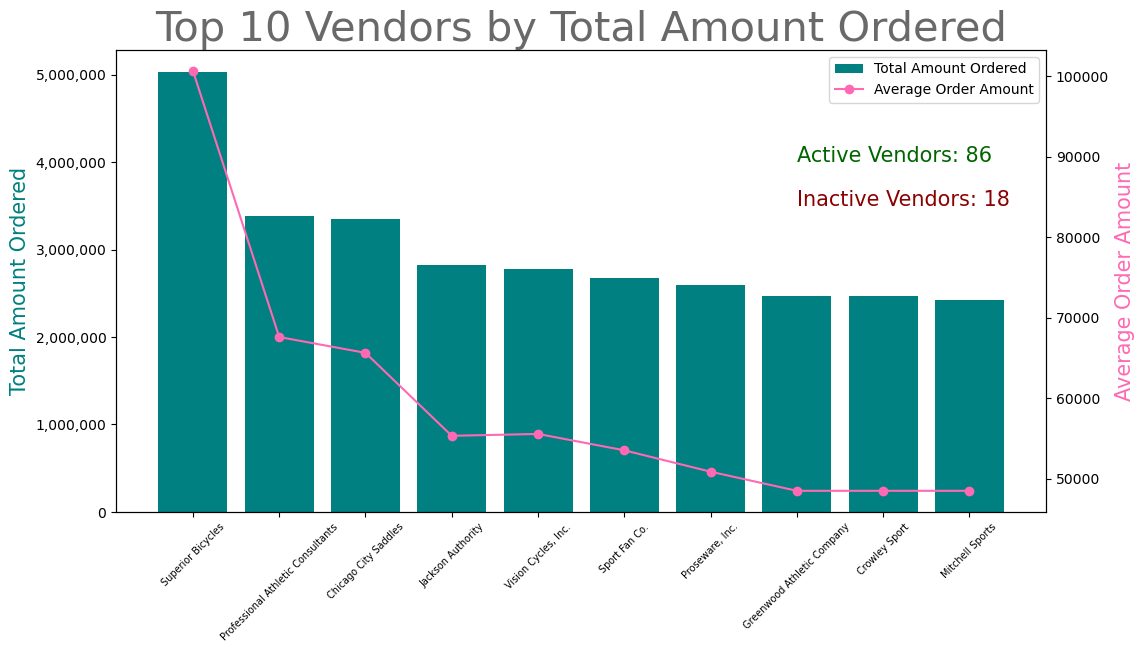

╒════╤════════════════════╤══════════════════════════╕
│    │   BusinessEntityID │ NOT ACTIVE               │
╞════╪════════════════════╪══════════════════════════╡
│  0 │               1502 │ Cycling Master           │
├────┼────────────────────┼──────────────────────────┤
│  1 │               1512 │ Light Speed              │
├────┼────────────────────┼──────────────────────────┤
│  2 │               1524 │ Recreation Place         │
├────┼────────────────────┼──────────────────────────┤
│  3 │               1528 │ Image Makers Bike Center │
├────┼────────────────────┼──────────────────────────┤
│  4 │               1532 │ Knopfler Cycles          │
├────┼────────────────────┼──────────────────────────┤
│  5 │               1550 │ Merit Bikes              │
├────┼────────────────────┼──────────────────────────┤
│  6 │               1552 │ Sports House             │
├────┼────────────────────┼──────────────────────────┤
│  7 │               1558 │ Marsh                    │
├────┼────

In [6]:
#Identifying supplier performance in terms of order volume and value
purchase_query= """
SELECT TOP (10)
    B.Name AS 'Vendor Name', 
    SUM(A.TotalDue) AS 'Total Amount Ordered',
    AVG(A.TotalDue) AS 'Average Order Amount'
FROM Purchasing.PurchaseOrderHeader AS A
JOIN  Purchasing.Vendor AS B
    ON B.BusinessEntityID = A.VendorID
GROUP BY B.Name
ORDER BY SUM(A.TotalDue) DESC;"""

purchase_data= pd.read_sql(sql=purchase_query, con=connection)
print(tabulate(purchase_data, headers='keys', tablefmt='fancy_grid'))

#Creating a dual axis to visualize both the total amount ordered and average order amount for each supplier.
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_title('Top 10 Vendors by Total Amount Ordered', size=30, color='dimgray')

ax2 = ax1.twinx() 
bar_plot = ax1.bar(purchase_data['Vendor Name'], purchase_data['Total Amount Ordered'], color='teal')
line_plot = ax2.plot(purchase_data['Vendor Name'], purchase_data['Average Order Amount'], color='hotpink', marker='o')

ax1.set_ylabel('Total Amount Ordered', color='teal', size=15)
ax2.set_ylabel('Average Order Amount', color='hotpink', size=15)

#Displaying sales figures in a readable format
ax1.yaxis.set_major_formatter(lambda x, _: '{:,}'.format(int(x)))

ax1.tick_params(axis='x', rotation=45, labelsize=7)

ax1.legend([bar_plot, line_plot[0]], ['Total Amount Ordered', 'Average Order Amount'], loc='upper right')

#Additional text to provide more insightful context
ax1.text(7,4000000, f'Active Vendors: 86', fontsize=15, color='darkgreen')
ax1.text(7,3500000, f'Inactive Vendors: 18', fontsize=15, color='darkred')

plt.show()

#Which suppliers are not active?
notactive_query = """ 
SELECT
    B.BusinessEntityID, 
    B.Name AS 'NOT ACTIVE'
FROM Purchasing.Vendor AS B
LEFT JOIN Purchasing.PurchaseOrderHeader AS A 
    ON B.BusinessEntityID = A.VendorID
WHERE A.VendorID IS NULL; """

notactive_data = pd.read_sql(sql=notactive_query, con=connection)
print(tabulate(notactive_data, headers='keys', tablefmt='fancy_grid'))


#This code verifies the relational integrity of Vendor ID and BusinessEntityID
#checkid_query = """
#SELECT DISTINCT PurchaseOrderHeader.VendorID,
#        Vendor.BusinessEntityID,
#        Vendor.Name
#FROM Purchasing.PurchaseOrderHeader
#JOIN Purchasing.Vendor
#    ON PurchaseOrderHeader.VendorID = Vendor.BusinessEntityID
#ORDER BY VendorID """
#checkid_data = pd.read_sql(sql=checkid_query, con=connection)
#pd.set_option('display.max_rows', None)
#checkid_data

## 1.3 Manufacturing analysis
- Which products have the highest work order amount?
- What is the average time to complete?

In [7]:
#Identifying which products are most in demand and how efficient they are in terms of manufacturing
product_query = """
SELECT TOP (10)
    Name AS 'Product Name', 
    COUNT(*) AS 'Number Of Work Orders',
    AVG(DATEDIFF(day, A.StartDate, A.EndDate)) AS 'Average Days To Complete'
FROM Production.WorkOrder AS A
JOIN Production.Product AS B 
    ON A.ProductID = B.ProductID
GROUP BY Name
ORDER BY 'Number Of Work Orders' DESC"""

product_data= pd.read_sql(sql=product_query, con=connection)
print(tabulate(product_data, headers='keys', tablefmt='fancy_grid'))

╒════╤══════════════════╤═════════════════════════╤════════════════════════════╕
│    │ Product Name     │   Number Of Work Orders │   Average Days To Complete │
╞════╪══════════════════╪═════════════════════════╪════════════════════════════╡
│  0 │ Front Derailleur │                    1105 │                         15 │
├────┼──────────────────┼─────────────────────────┼────────────────────────────┤
│  1 │ HL Fork          │                    1104 │                         15 │
├────┼──────────────────┼─────────────────────────┼────────────────────────────┤
│  2 │ Rear Derailleur  │                    1102 │                         15 │
├────┼──────────────────┼─────────────────────────┼────────────────────────────┤
│  3 │ Top Tube         │                    1093 │                         10 │
├────┼──────────────────┼─────────────────────────┼────────────────────────────┤
│  4 │ Fork Crown       │                    1093 │                         10 │
├────┼──────────────────┼───

## 1.4 Customer analysis
- Which cities have the most customers?
- Are the cities with most customers also the cities with the highest sales?

╒════╤═════════════╤═══════════════════════╕
│    │ City        │   Number of Customers │
╞════╪═════════════╪═══════════════════════╡
│  0 │ London      │                   420 │
├────┼─────────────┼───────────────────────┤
│  1 │ Paris       │                   386 │
├────┼─────────────┼───────────────────────┤
│  2 │ Burien      │                   212 │
├────┼─────────────┼───────────────────────┤
│  3 │ Concord     │                   212 │
├────┼─────────────┼───────────────────────┤
│  4 │ Bellingham  │                   210 │
├────┼─────────────┼───────────────────────┤
│  5 │ Beaverton   │                   210 │
├────┼─────────────┼───────────────────────┤
│  6 │ Chula Vista │                   206 │
├────┼─────────────┼───────────────────────┤
│  7 │ Berkeley    │                   200 │
├────┼─────────────┼───────────────────────┤
│  8 │ Burlingame  │                   198 │
├────┼─────────────┼───────────────────────┤
│  9 │ Bellflower  │                   194 │
╘════╧════

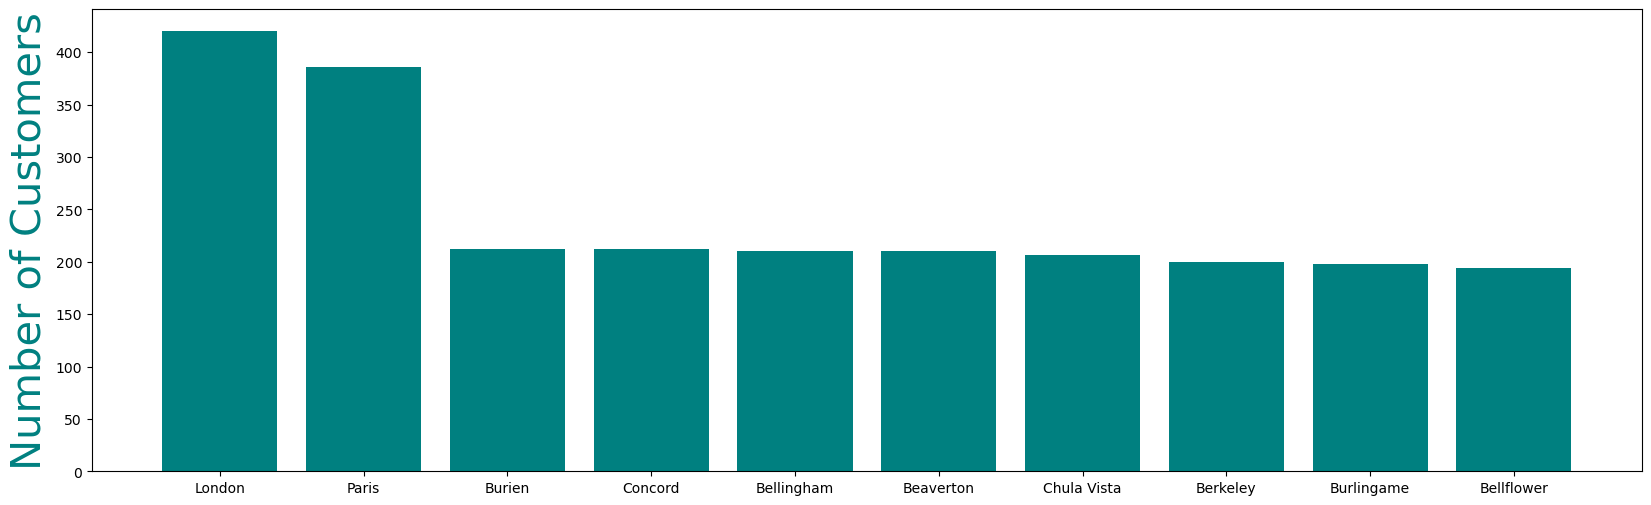

╒════╤══════════╤═══════════════╤════════════════╕
│    │ City     │   TotalOrders │   TotalRevenue │
╞════╪══════════╪═══════════════╪════════════════╡
│  0 │ Toronto  │           176 │    5.03427e+06 │
├────┼──────────┼───────────────┼────────────────┤
│  1 │ London   │           756 │    3.07118e+06 │
├────┼──────────┼───────────────┼────────────────┤
│  2 │ Paris    │           575 │    2.23381e+06 │
├────┼──────────┼───────────────┼────────────────┤
│  3 │ Seattle  │           134 │    1.76731e+06 │
├────┼──────────┼───────────────┼────────────────┤
│  4 │ Burnaby  │            98 │    1.50346e+06 │
├────┼──────────┼───────────────┼────────────────┤
│  5 │ Richmond │            43 │    1.41926e+06 │
├────┼──────────┼───────────────┼────────────────┤
│  6 │ Montreal │            75 │    1.27467e+06 │
├────┼──────────┼───────────────┼────────────────┤
│  7 │ Garland  │            24 │    1.26779e+06 │
├────┼──────────┼───────────────┼────────────────┤
│  8 │ Memphis  │            27

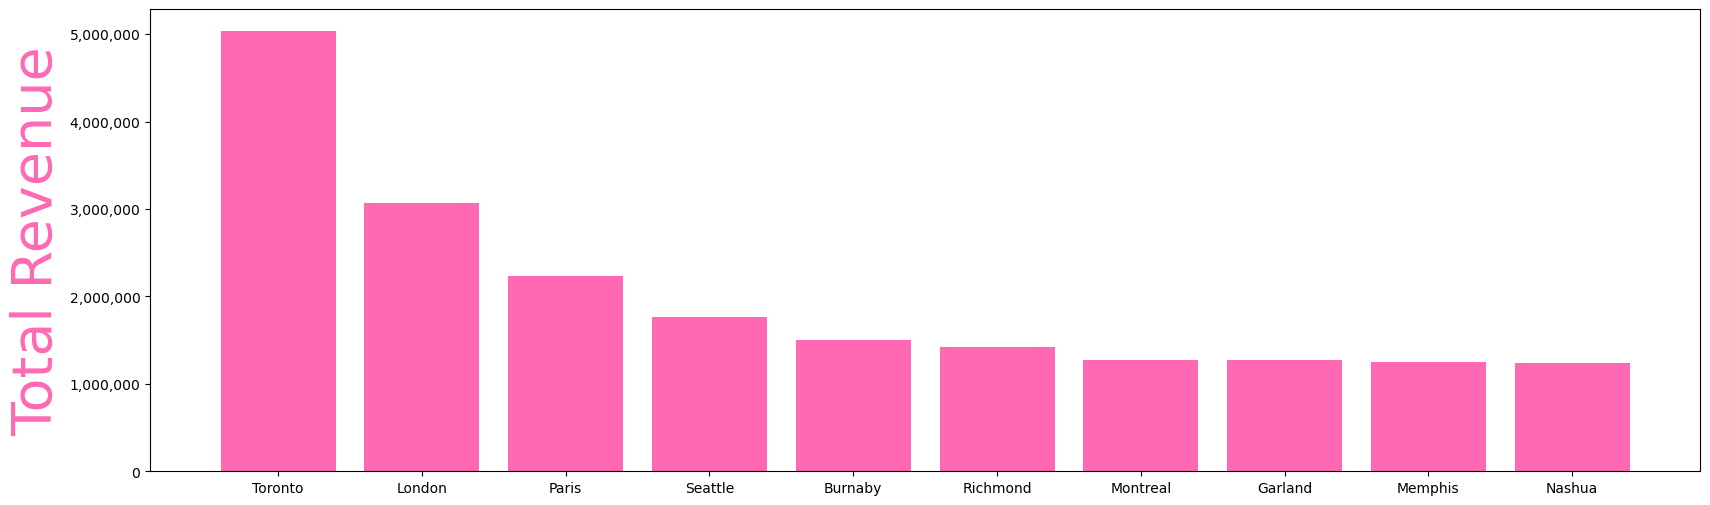

In [9]:
#Identifying the top 10 cities with the highest number of customers
top_cities_query = """
SELECT TOP (10) 
    City, 
    COUNT(*) AS 'Number of Customers'
FROM Person.Address 
JOIN Person.BusinessEntityAddress 
    ON Address.AddressID = BusinessEntityAddress.AddressID
JOIN Person.Person 
    ON BusinessEntityAddress.BusinessEntityID = Person.BusinessEntityID
GROUP BY City 
ORDER BY 'Number of Customers' DESC;"""

top_cities = pd.read_sql(sql=top_cities_query, con=connection)
print(tabulate(top_cities, headers='keys', tablefmt='fancy_grid'))

#Creating a bar chart to visually represent the number of customers in the top 10 cities
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(top_cities['City'], top_cities['Number of Customers'], color='teal')
ax.set_ylabel('Number of Customers',size=30, color="teal")
plt.show()

#Identifying if high customer numbers correlates with high revenue
city_query = """
SELECT TOP (10)
    Address.City,
    COUNT(SalesOrderHeader.SalesOrderID) AS 'TotalOrders',
    SUM(SalesOrderHeader.TotalDue) AS 'TotalRevenue'
FROM Sales.SalesOrderHeader
JOIN Person.Address 
ON Sales.SalesOrderHeader.BillToAddressID = Person.Address.AddressID
GROUP BY Address.City
ORDER BY 'TotalRevenue' DESC;"""

city_data = pd.read_sql(sql= city_query, con=connection)
print(tabulate(city_data, headers='keys', tablefmt='fancy_grid'))

#Visualizing through a bar chart, highlighting revenue differences
fig, ax = plt.subplots(figsize=(20, 6))
ax.bar(city_data['City'], city_data['TotalRevenue'], color='hotpink')
ax.set_ylabel('Total Revenue', size=40, color='hotpink')

#Displaying sales figures in a readable format
ax.yaxis.set_major_formatter(lambda x, _: '{:,}'.format(int(x)))

plt.show()

## 1.5 Sales performance
- Which product categories are performing the best?

╒════╤════════════════════╤══════════════════╤═══════════════════════╕
│    │ Product Category   │      Total Sales │   Total Quantity Sold │
╞════╪════════════════════╪══════════════════╪═══════════════════════╡
│  0 │ Clothing           │ 479781           │                 18627 │
├────┼────────────────────┼──────────────────┼───────────────────────┤
│  1 │ Bikes              │      4.60105e+06 │                  7526 │
├────┼────────────────────┼──────────────────┼───────────────────────┤
│  2 │ Accessories        │ 143811           │                  6586 │
├────┼────────────────────┼──────────────────┼───────────────────────┤
│  3 │ Components         │ 198051           │                  1080 │
╘════╧════════════════════╧══════════════════╧═══════════════════════╛


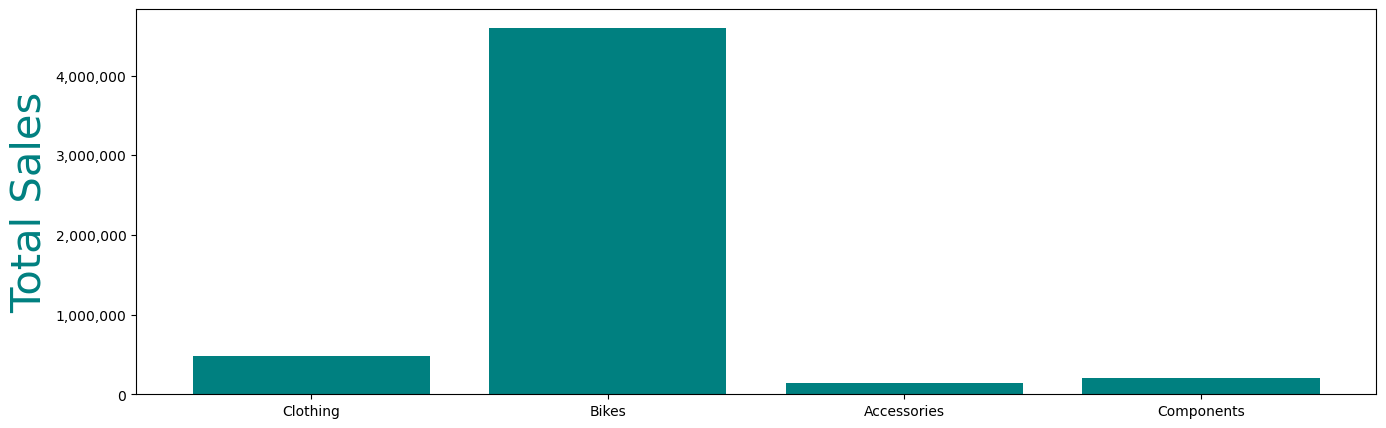

In [10]:
#Identifying which product categories are the most successful in terms of sales
sales_query = """
SELECT 
       D.Name AS 'Product Category', 
       SUM(ROUND(A.LineTotal,2)) AS 'Total Sales', 
       SUM(A.OrderQty) AS 'Total Quantity Sold'
FROM Sales.SalesOrderDetail AS A
JOIN Production.Product AS B 
    ON A.ProductID = B.ProductID
JOIN Production.ProductSubcategory AS C 
    ON B.ProductSubcategoryID = C.ProductSubcategoryID
JOIN Production.ProductCategory AS D
    ON C.ProductCategoryID = D.ProductCategoryID
WHERE A.UnitPriceDiscount > 0
GROUP BY D.Name;
"""

sales_data = pd.read_sql(sql=sales_query, con=connection)
print(tabulate(sales_data, headers='keys', tablefmt='fancy_grid'))

#Visualizing in a bar chart to compare the performance
fig, ax = plt.subplots(figsize=(16,5))
ax.bar(sales_data['Product Category'], sales_data['Total Sales'], color='teal')
ax.set_ylabel('Total Sales', size= 30, color='teal')

#Displaying sales figures in a readable format
ax.yaxis.set_major_formatter(lambda x, _: '{:,}'.format(int(x)))

plt.show()

# 2. Statistical analysis (Confidence interval)
- Using the following formula: $\overline{x} \pm t \cdot \frac{s}{\sqrt{\displaystyle n}}$ to calculate the confidence interval

### What is the 95% confidence interval for the average sales price of bicycles?

In [12]:
#Building on our sales performance insights,
#this section aims to statistically validate the average sales prices of bicycles

#Aggregating using SQL
ci_query = """
SELECT 
    AVG(ListPrice) AS 'Average List Price',
    STDEV(ListPrice) AS 'Standard Deviation',
    COUNT(*) AS 'Sample Size'
FROM Production.Product AS A
JOIN Production.ProductSubcategory AS B
    ON A.ProductSubcategoryID = B.ProductSubcategoryID
JOIN Production.ProductCategory AS C
    ON B.ProductCategoryID = C.ProductCategoryID
WHERE C.Name = 'Bikes'
AND A.SellStartDate BETWEEN '2011-01-01' AND '2014-12-31';"""

ci_data = pd.read_sql(sql=ci_query, con=connection)

print(tabulate(ci_data, headers='keys', tablefmt='fancy_grid'))

mean = ci_data['Average List Price'].iloc[0]
std = ci_data['Standard Deviation'].iloc[0]
n = ci_data['Sample Size'].iloc[0]
ci_perc = 0.95

#Calculating a 95% confidence interval manually
quantile = t.ppf(1 - (1 - ci_perc) / 2, n-1)

ci_lower = mean - quantile*(std/np.sqrt(n))
ci_upper = mean + quantile*(std/np.sqrt(n))

print('Manual:', (ci_lower, ci_upper))
 
#Ensuring the reliabilty of the manual calculating using a built in fucntion
confidence_interval = t.interval(0.95, n-1, mean, std/np.sqrt(n))

print('Bilt in:', confidence_interval)

╒════╤══════════════════════╤══════════════════════╤═══════════════╕
│    │   Average List Price │   Standard Deviation │   Sample Size │
╞════╪══════════════════════╪══════════════════════╪═══════════════╡
│  0 │              1586.74 │              996.269 │            97 │
╘════╧══════════════════════╧══════════════════════╧═══════════════╛
Manual: (1385.944398291827, 1787.5296017081732)
Bilt in: (1385.944398291827, 1787.5296017081732)
